In [1]:
import os
import sys
import numpy as np
import re
import cv2

import matplotlib.pyplot as plt
import tensorflow as tf
from os import listdir
from tensorflow.keras.layers import *
from time import time
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import Model
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras import constraints
from tensorflow.keras.callbacks import *
from tensorflow.keras.applications.xception import Xception

C:\Users\NITK\anaconda3\envs\Shyam_Lal\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


Image 1 shape: (1024, 1024, 3)
Image 2 shape: (1024, 1024, 3)
Label shape: (1024, 1024)


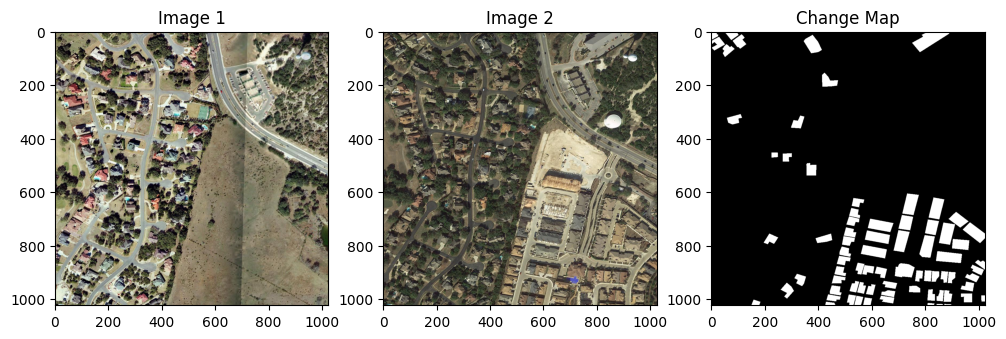

In [2]:
path = "D:/SujanD datasets/datasets/mdrifaturrahman33/levir-cd/versions/1/LEVIR CD"
image1 = cv2.imread(os.path.join(path, 'train/A/train_100.png'))
image2 = cv2.imread(os.path.join(path, 'train/B/train_100.png'))
label = cv2.imread(os.path.join(path, 'train/label/train_100.png'), 0)
print("Image 1 shape:", image1.shape)
print("Image 2 shape:", image2.shape )
print("Label shape:", label.shape)
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)); plt.title('Image 1')
plt.subplot(1,3,2); plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)); plt.title('Image 2')
plt.subplot(1,3,3); plt.imshow(label, cmap='gray'); plt.title('Change Map')
plt.show()


In [ ]:
import numpy as np
import cv2
import random
import tifffile as tiff
import tensorflow as tf
import os
import glob

class PatchDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, A_paths, B_paths, L_paths, 
                 batch_size=2, patch_size=512, 
                 change_ratio=0.7, num_classes=2, normalize=True):
        
        self.A_paths = sorted(A_paths)
        self.B_paths = sorted(B_paths)
        self.L_paths = sorted(L_paths)
        self.batch_size = batch_size
        self.patch_size = patch_size
        self.change_ratio = change_ratio
        self.num_classes = num_classes
        self.normalize = normalize
        self.idxs = np.arange(len(self.A_paths))
        
        assert len(self.A_paths) == len(self.B_paths) == len(self.L_paths), "Path lists must be equal length"

    def __len__(self):
        return len(self.idxs) // self.batch_size

    def __getitem__(self, idx):
        batch_A, batch_B, batch_L = [], [], []

        for _ in range(self.batch_size):
            while True:
                img_idx = random.choice(self.idxs)

                imgA = self._read_image(self.A_paths[img_idx])
                imgB = self._read_image(self.B_paths[img_idx])
                label = self._read_label(self.L_paths[img_idx])

                h, w = label.shape

                if h < self.patch_size or w < self.patch_size:
                    raise ValueError(f"Patch size {self.patch_size} is larger than image {h}x{w}")

                x_start = random.randint(0, h - self.patch_size)
                y_start = random.randint(0, w - self.patch_size)

                patchA = imgA[x_start:x_start+self.patch_size, y_start:y_start+self.patch_size, :]
                patchB = imgB[x_start:x_start+self.patch_size, y_start:y_start+self.patch_size, :]
                patchL = label[x_start:x_start+self.patch_size, y_start:y_start+self.patch_size]

                change_fraction = np.sum(patchL == 1) / (self.patch_size ** 2)

                if change_fraction > 0.01:  
                    if random.random() < self.change_ratio:
                        break
                else:
                    if random.random() > self.change_ratio:
                        break

            batch_A.append(patchA)
            batch_B.append(patchB)
            batch_L.append(tf.keras.utils.to_categorical(patchL, num_classes=self.num_classes))

        return [np.array(batch_A), np.array(batch_B)], np.array(batch_L)

    def _read_image(self, path):
        if path.lower().endswith(('.tif', '.tiff')):
            img = tiff.imread(path).astype(np.float32)
        else:
            img = cv2.imread(path, cv2.IMREAD_UNCHANGED).astype(np.float32)
            if img.ndim == 2:  
                img = np.expand_dims(img, axis=-1)
        if self.normalize:
            img /= 255.0 if img.max() > 1.0 else 1.0
        return img

    def _read_label(self, path):
        label = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        label = (label > 127).astype(np.uint8)  
        return label


train_A_folder = r"D:\SujanD datasets\datasets\mdrifaturrahman33\levir-cd\versions\1\LEVIR CD\train\A_resized"
train_B_folder = "D:/SujanD datasets/datasets/mdrifaturrahman33/levir-cd/versions/1/LEVIR CD/train/B_resized"
train_L_folder = "D:/SujanD datasets/datasets/mdrifaturrahman33/levir-cd/versions/1/LEVIR CD/train/label_resized"
train_A_paths = sorted(glob.glob(os.path.join(train_A_folder, "*.png")))
train_B_paths = sorted(glob.glob(os.path.join(train_B_folder, "*.png")))
train_L_paths = sorted(glob.glob(os.path.join(train_L_folder, "*.png")))

test_A_folder = r"D:/SujanD datasets/datasets/mdrifaturrahman33/levir-cd/versions/1/LEVIR CD/test/A_resized"
test_B_folder = r"D:/SujanD datasets/datasets/mdrifaturrahman33/levir-cd/versions/1/LEVIR CD/test/B_resized"
test_L_folder = r"D:/SujanD datasets/datasets/mdrifaturrahman33/levir-cd/versions/1/LEVIR CD/test/label_resized"
test_A_paths = sorted(glob.glob(os.path.join(test_A_folder, "*.[pP][nN][gG]")))
test_B_paths = sorted(glob.glob(os.path.join(test_B_folder, "*.[pP][nN][gG]")))
test_L_paths = sorted(glob.glob(os.path.join(test_L_folder, "*.[pP][nN][gG]")))

validation_A_folder = r"D:/SujanD datasets/datasets/mdrifaturrahman33/levir-cd/versions/1/LEVIR CD/val/A_resized"
validation_B_folder = r"D:/SujanD datasets/datasets/mdrifaturrahman33/levir-cd/versions/1/LEVIR CD/val/B_resized"
validation_L_folder = r"D:/SujanD datasets/datasets/mdrifaturrahman33/levir-cd/versions/1/LEVIR CD/val/label_resized"
validation_A_paths = sorted(glob.glob(os.path.join(validation_A_folder, "*.[pP][nN][gG]")))
validation_B_paths = sorted(glob.glob(os.path.join(validation_B_folder, "*.[pP][nN][gG]")))
validation_L_paths = sorted(glob.glob(os.path.join(validation_L_folder, "*.[pP][nN][gG]")))

train_gen = PatchDataGenerator(train_A_paths, train_B_paths, train_L_paths, 
                               batch_size=2, patch_size=512, change_ratio=0.7, num_classes=2)

val_gen = PatchDataGenerator(validation_A_paths, validation_B_paths, validation_L_paths, 
                             batch_size=2, patch_size=512, change_ratio=0.5, num_classes=2)

test_gen = PatchDataGenerator(test_A_paths, test_B_paths, test_L_paths, 
                             batch_size=2, patch_size=512, change_ratio=0.5, num_classes=2)

# model.fit(train_gen, validation_data=val_gen, epochs=80)


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, MaxPooling2D, UpSampling2D, Concatenate, Input


def res_block(x, filters, downsample=False):
    shortcut = x
    strides = 2 if downsample else 1

    x = Conv2D(filters, 3, strides=strides, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(filters, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)

    if downsample or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, 1, strides=strides, padding='same', use_bias=False)(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = tf.keras.layers.Add()([x, shortcut])
    x = ReLU()(x)
    return x


def MsResNet_like_backbone(inp):
    x = Conv2D(32, 7, strides=2, padding='same', use_bias=False)(inp) 
    x = BatchNormalization()(x)
    x = ReLU()(x)
    s0 = x 

    x = MaxPooling2D(3, strides=2, padding='same')(x) 

    x = res_block(x, 64, downsample=False)
    x = res_block(x, 64, downsample=False)
    s1 = x 

    x = res_block(x, 128, downsample=True)
    x = res_block(x, 128, downsample=False)
    s2 = x 

    x = res_block(x, 256, downsample=True)
    x = res_block(x, 256, downsample=False)
    s3 = x 

    x = res_block(x, 512, downsample=True)
    x = res_block(x, 512, downsample=False)
    s4 = x 

    return s0, s1, s2, s3, s4


def safe_concat(x, skip):
    if x.shape[1] != skip.shape[1] or x.shape[2] != skip.shape[2]:
        skip = tf.image.resize(skip, (x.shape[1], x.shape[2]))
    return Concatenate()([x, skip])


def decoder(s0, s1, s2, s3, s4, num_classes=2):
    x = s4

    x = UpSampling2D(size=(2, 2), interpolation='bilinear')(x)
    x = safe_concat(x, s3)
    x = Conv2D(256, 3, padding='same', activation='relu')(x)

    x = UpSampling2D(size=(2, 2), interpolation='bilinear')(x)
    x = safe_concat(x, s2)
    x = Conv2D(128, 3, padding='same', activation='relu')(x)

    x = UpSampling2D(size=(2, 2), interpolation='bilinear')(x)
    x = safe_concat(x, s1)
    x = Conv2D(64, 3, padding='same', activation='relu')(x)

    x = UpSampling2D(size=(2, 2), interpolation='bilinear')(x)
    x = safe_concat(x, s0)
    x = Conv2D(32, 3, padding='same', activation='relu')(x)

    x = UpSampling2D(size=(2, 2), interpolation='bilinear')(x)
    out = Conv2D(num_classes, 1, activation='softmax')(x)

    return out


def build_ecfnet(input_shape=(512, 512, 3), num_classes=2):
    inpA = Input(shape=input_shape, name='image_A')
    inpB = Input(shape=input_shape, name='image_B')

    s0_A, s1_A, s2_A, s3_A, s4_A = MsResNet_like_backbone(inpA)
    s0_B, s1_B, s2_B, s3_B, s4_B = MsResNet_like_backbone(inpB)

    s0 = tf.abs(s0_A - s0_B)
    s1 = tf.abs(s1_A - s1_B)
    s2 = tf.abs(s2_A - s2_B)
    s3 = tf.abs(s3_A - s3_B)
    s4 = tf.abs(s4_A - s4_B)

    out = decoder(s0, s1, s2, s3, s4, num_classes=num_classes)

    return tf.keras.Model(inputs=[inpA, inpB], outputs=out)

model = build_ecfnet(input_shape=(256, 256, 3), num_classes=2)
model.summary()


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_A (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
image_B (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_189 (Conv2D)             (None, 128, 128, 32) 4704        image_A[0][0]                    
__________________________________________________________________________________________________
conv2d_210 (Conv2D)             (None, 128, 128, 32) 4704        image_B[0][0]                    
____________________________________________________________________________________________

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

def weighted_bce_dice_loss(y_true, y_pred):

    weights = tf.constant([0.5, 2.0], dtype=tf.float32)  
    y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
    
    bce = -tf.reduce_mean(
        tf.reduce_sum(y_true * tf.math.log(y_pred) * weights, axis=-1)
    )

    smooth = 1e-6
    intersection = tf.reduce_sum(y_true[...,1] * y_pred[...,1])
    union = tf.reduce_sum(y_true[...,1]) + tf.reduce_sum(y_pred[...,1])
    dice_loss = 1 - (2. * intersection + smooth) / (union + smooth)

    return bce + dice_loss


In [17]:
import tensorflow_addons as tfa

model.compile(
    optimizer=tfa.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-3),
    loss=bce_dice_loss,
    metrics=['accuracy']
)
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=200,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-6),
        tf.keras.callbacks.ModelCheckpoint('ecfnet_best striking again.h5', save_best_only=True, monitor='val_loss', mode='min'),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    ]
)


Epoch 1/200
890/890 [==============================] - 1593s 2s/step - loss: 0.6924 - accuracy: 0.9506 - val_loss: 1.1771 - val_accuracy: 0.9495
Epoch 2/200
890/890 [==============================] - 1588s 2s/step - loss: 0.5471 - accuracy: 0.9670 - val_loss: 1.1501 - val_accuracy: 0.9557
Epoch 3/200
890/890 [==============================] - 1586s 2s/step - loss: 0.5700 - accuracy: 0.9688 - val_loss: 0.7002 - val_accuracy: 0.9825
Epoch 4/200
890/890 [==============================] - 1586s 2s/step - loss: 0.6283 - accuracy: 0.9647 - val_loss: 1.0064 - val_accuracy: 0.9516
Epoch 5/200
890/890 [==============================] - 1583s 2s/step - loss: 0.6577 - accuracy: 0.9605 - val_loss: 1.1762 - val_accuracy: 0.8426
Epoch 6/200
890/890 [==============================] - 1581s 2s/step - loss: 0.6673 - accuracy: 0.9591 - val_loss: 0.9436 - val_accuracy: 0.9687
Epoch 7/200
890/890 [==============================] - 1578s 2s/step - loss: 0.6685 - accuracy: 0.9604 - val_loss: 1.1253 - val_ac

KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_addons as tfa
import numpy as np
import cv2, os, glob, random, tifffile as tiff


def weighted_bce_dice_loss(y_true, y_pred):
    weights = K.constant([0.5, 2.5]) 
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    bce = tf.reduce_mean(bce * tf.reduce_sum(weights * y_true, axis=-1))

    smooth = 1.0
    y_true_f = K.flatten(y_true[..., 1]) 
    y_pred_f = K.flatten(y_pred[..., 1])
    intersection = K.sum(y_true_f * y_pred_f)
    dice = 1 - ((2. * intersection + smooth) /
                (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))

    return bce + dice

def iou_metric(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=-1)
    y_true = tf.argmax(y_true, axis=-1)
    intersection = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32))
    union = tf.reduce_sum(tf.cast(y_true + y_pred, tf.float32)) - intersection
    return (intersection + 1e-7) / (union + 1e-7)

def f1_metric(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=-1)
    y_true = tf.argmax(y_true, axis=-1)
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32))
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, tf.float32))
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), tf.float32))
    precision = tp / (tp + fp + 1e-7)
    recall = tp / (tp + fn + 1e-7)
    return 2 * precision * recall / (precision + recall + 1e-7)


class PatchDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, A_paths, B_paths, L_paths,
                 batch_size=4, patch_size=512,
                 change_ratio=0.7, num_classes=2, normalize=True):
        self.A_paths = sorted(A_paths)
        self.B_paths = sorted(B_paths)
        self.L_paths = sorted(L_paths)
        self.batch_size = batch_size
        self.patch_size = patch_size
        self.change_ratio = change_ratio
        self.num_classes = num_classes
        self.normalize = normalize
        self.idxs = np.arange(len(self.A_paths))
        assert len(self.A_paths) == len(self.B_paths) == len(self.L_paths), "Path lists must be equal length"

    def __len__(self):
        return len(self.idxs) // self.batch_size

    def __getitem__(self, idx):
        batch_A, batch_B, batch_L = [], [], []
        for _ in range(self.batch_size):
            while True:
                img_idx = random.choice(self.idxs)
                imgA = self._read_image(self.A_paths[img_idx])
                imgB = self._read_image(self.B_paths[img_idx])
                label = self._read_label(self.L_paths[img_idx])
                h, w = label.shape
                if h < self.patch_size or w < self.patch_size:
                    raise ValueError(f"Patch size {self.patch_size} is larger than image {h}x{w}")
                x_start = random.randint(0, h - self.patch_size)
                y_start = random.randint(0, w - self.patch_size)
                patchA = imgA[x_start:x_start+self.patch_size, y_start:y_start+self.patch_size, :]
                patchB = imgB[x_start:x_start+self.patch_size, y_start:y_start+self.patch_size, :]
                patchL = label[x_start:x_start+self.patch_size, y_start:y_start+self.patch_size]
                change_fraction = np.sum(patchL == 1) / (self.patch_size ** 2)
                if change_fraction > 0.01:
                    if random.random() < self.change_ratio:
                        break
                else:
                    if random.random() > self.change_ratio:
                        break
            batch_A.append(patchA)
            batch_B.append(patchB)
            batch_L.append(tf.keras.utils.to_categorical(patchL, num_classes=self.num_classes))
        return [np.array(batch_A), np.array(batch_B)], np.array(batch_L)

    def _read_image(self, path):
        if path.lower().endswith(('.tif', '.tiff')):
            img = tiff.imread(path).astype(np.float32)
        else:
            img = cv2.imread(path, cv2.IMREAD_UNCHANGED).astype(np.float32)
            if img.ndim == 2:
                img = np.expand_dims(img, axis=-1)
        if self.normalize:
            img /= 255.0 if img.max() > 1.0 else 1.0
        return img

    def _read_label(self, path):
        label = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        label = (label > 127).astype(np.uint8)
        return label


train_A_folder = r"D:\SujanD datasets\datasets\mdrifaturrahman33\levir-cd\versions\1\LEVIR CD\train\A_resized"
train_B_folder = "D:/SujanD datasets/datasets/mdrifaturrahman33/levir-cd/versions/1/LEVIR CD/train/B_resized"
train_L_folder = "D:/SujanD datasets/datasets/mdrifaturrahman33/levir-cd/versions/1/LEVIR CD/train/label_resized"
train_A_paths = sorted(glob.glob(os.path.join(train_A_folder, "*.png")))
train_B_paths = sorted(glob.glob(os.path.join(train_B_folder, "*.png")))
train_L_paths = sorted(glob.glob(os.path.join(train_L_folder, "*.png")))

test_A_folder = r"D:/SujanD datasets/datasets/mdrifaturrahman33/levir-cd/versions/1/LEVIR CD/test/A_resized"
test_B_folder = r"D:/SujanD datasets/datasets/mdrifaturrahman33/levir-cd/versions/1/LEVIR CD/test/B_resized"
test_L_folder = r"D:/SujanD datasets/datasets/mdrifaturrahman33/levir-cd/versions/1/LEVIR CD/test/label_resized"
test_A_paths = sorted(glob.glob(os.path.join(test_A_folder, "*.[pP][nN][gG]")))
test_B_paths = sorted(glob.glob(os.path.join(test_B_folder, "*.[pP][nN][gG]")))
test_L_paths = sorted(glob.glob(os.path.join(test_L_folder, "*.[pP][nN][gG]")))

val_A_folder = r"D:/SujanD datasets/datasets/mdrifaturrahman33/levir-cd/versions/1/LEVIR CD/val/A_resized"
val_B_folder = r"D:/SujanD datasets/datasets/mdrifaturrahman33/levir-cd/versions/1/LEVIR CD/val/B_resized"
val_L_folder = r"D:/SujanD datasets/datasets/mdrifaturrahman33/levir-cd/versions/1/LEVIR CD/val/label_resized"
val_A_paths = sorted(glob.glob(os.path.join(val_A_folder, "*.[pP][nN][gG]")))
val_B_paths = sorted(glob.glob(os.path.join(val_B_folder, "*.[pP][nN][gG]")))
val_L_paths = sorted(glob.glob(os.path.join(val_L_folder, "*.[pP][nN][gG]")))


train_gen = PatchDataGenerator(train_A_paths, train_B_paths, train_L_paths, batch_size=4, patch_size=256)
val_gen = PatchDataGenerator(val_A_paths, val_B_paths, val_L_paths, batch_size=4, patch_size=256)

model.compile(
    optimizer=tfa.optimizers.AdamW(learning_rate=5e-5, weight_decay=1e-4),
    loss=weighted_bce_dice_loss,
    metrics=['accuracy', iou_metric, f1_metric]
)

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=1e-6, verbose=1),
    tf.keras.callbacks.ModelCheckpoint('ecfnet_best.h5', save_best_only=True, monitor='val_loss', mode='min'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=200,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/200
445/445 [==============================] - 55s 116ms/step - loss: 0.7500 - accuracy: 0.9206 - iou_metric: 0.3334 - f1_metric: 0.4861 - val_loss: 1.4221 - val_accuracy: 0.9362 - val_iou_metric: 0.0876 - val_f1_metric: 0.1523


C:\Users\NITK\anaconda3\envs\Shyam_Lal\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/200
445/445 [==============================] - 52s 116ms/step - loss: 0.5693 - accuracy: 0.9481 - iou_metric: 0.4528 - f1_metric: 0.6127 - val_loss: 0.4694 - val_accuracy: 0.9691 - val_iou_metric: 0.4839 - val_f1_metric: 0.6437
Epoch 3/200
445/445 [==============================] - 52s 116ms/step - loss: 0.4938 - accuracy: 0.9549 - iou_metric: 0.5069 - f1_metric: 0.6642 - val_loss: 0.5046 - val_accuracy: 0.9469 - val_iou_metric: 0.4659 - val_f1_metric: 0.6240
Epoch 4/200
445/445 [==============================] - 52s 116ms/step - loss: 0.4673 - accuracy: 0.9595 - iou_metric: 0.5242 - f1_metric: 0.6775 - val_loss: 0.5236 - val_accuracy: 0.9422 - val_iou_metric: 0.4456 - val_f1_metric: 0.6089
Epoch 5/200
445/445 [==============================] - 51s 115ms/step - loss: 0.4396 - accuracy: 0.9615 - iou_metric: 0.5462 - f1_metric: 0.6994 - val_loss: 0.4066 - val_accuracy: 0.9690 - val_iou_metric: 0.5498 - val_f1_metric: 0.7049
Epoch 6/200
445/445 [==============================] - 5

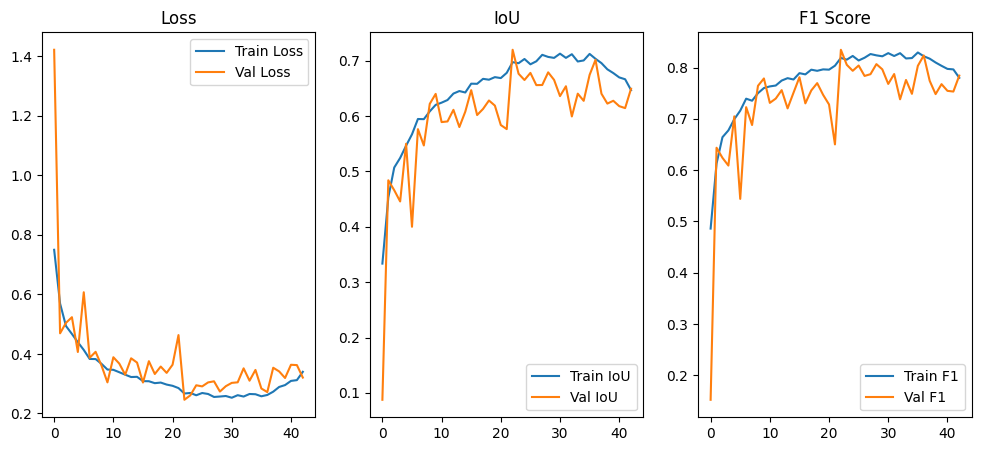

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,3,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

# IoU
plt.subplot(1,3,2)
plt.plot(history.history['iou_metric'], label='Train IoU')
plt.plot(history.history['val_iou_metric'], label='Val IoU')
plt.legend()
plt.title('IoU')

# F1
plt.subplot(1,3,3)
plt.plot(history.history['f1_metric'], label='Train F1')
plt.plot(history.history['val_f1_metric'], label='Val F1')
plt.legend()
plt.title('F1 Score')

plt.show()


In [ ]:
test_gen = PatchDataGenerator(
    test_A_paths, test_B_paths, test_L_paths,
    batch_size=1, patch_size=256 
)
model.evaluate(test_gen)


128/128 [==============================] - 5s 27ms/step - loss: 0.4188 - accuracy: 0.9725 - iou_metric: 0.6795 - f1_metric: 0.5694


[0.41882866621017456,
 0.9725193977355957,
 0.6795392036437988,
 0.5694180130958557]

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, cohen_kappa_score, precision_score, recall_score, f1_score

def evaluate_change_detection(model, test_gen, threshold=0.65):
    all_preds = []
    all_labels = []

    for batch in test_gen:
        imgsA, imgsB = batch[0]   
        labels = batch[1]      

        preds = model.predict([imgsA, imgsB], verbose=0)
        preds_bin = (preds[..., 1] > threshold).astype(np.uint8)  
        labels_bin = labels[..., 1].astype(np.uint8)

        all_preds.append(preds_bin.flatten())
        all_labels.append(labels_bin.flatten())

    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_labels)

    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    iou = tp / (tp + fp + fn + 1e-7)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)

    print("📊 Evaluation Results")
    print(f"IoU:       {iou:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"Kappa:     {kappa:.4f}")

evaluate_change_detection(model, test_gen)


📊 Evaluation Results
IoU:       0.6924
Precision: 0.8111
Recall:    0.8254
F1 Score:  0.8182
Kappa:     0.8043


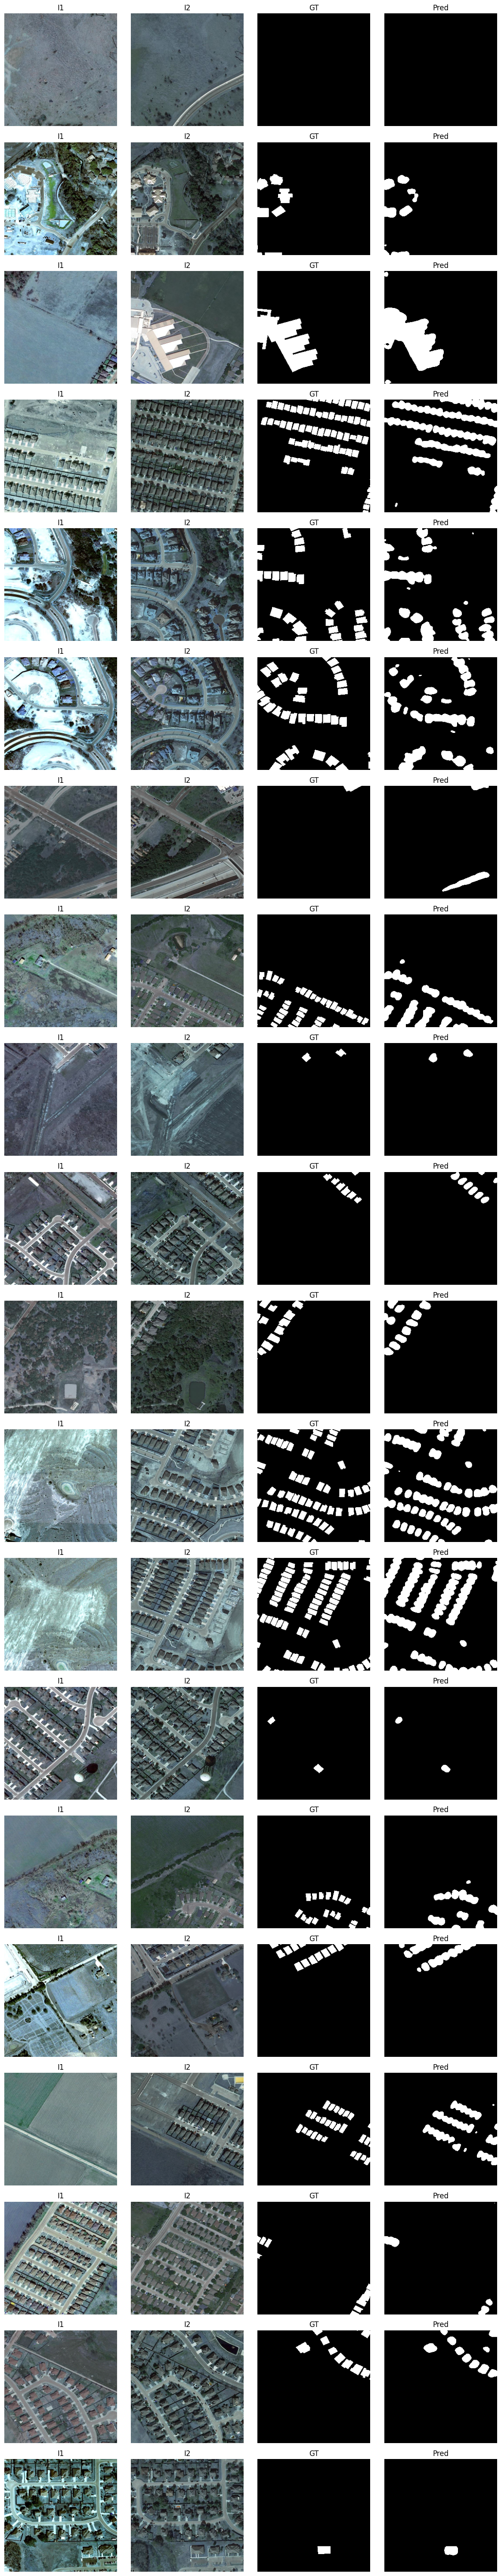

In [ ]:
import matplotlib.pyplot as plt

test_gen = PatchDataGenerator(
    test_A_paths, test_B_paths, test_L_paths,
    batch_size=1, patch_size=256
)

num_samples = 20
plt.figure(figsize=(12, num_samples * 3))

for i in range(num_samples):
    (A_img, B_img), label = test_gen[i]
    
    pred = model.predict([A_img, B_img], verbose=0)
    pred_mask = np.argmax(pred[0], axis=-1)  
    
    I1 = A_img[0]
    I2 = B_img[0]
    GT = np.argmax(label[0], axis=-1)  

    plt.subplot(num_samples, 4, i*4 + 1)
    plt.imshow(I1)
    plt.axis('off')
    plt.title("I1")

    plt.subplot(num_samples, 4, i*4 + 2)
    plt.imshow(I2)
    plt.axis('off')
    plt.title("I2")

    plt.subplot(num_samples, 4, i*4 + 3)
    plt.imshow(GT, cmap='gray')
    plt.axis('off')
    plt.title("GT")

    plt.subplot(num_samples, 4, i*4 + 4)
    plt.imshow(pred_mask, cmap='gray')
    plt.axis('off')
    plt.title("Pred")

plt.tight_layout()
plt.show()
